# LFADS Quantization-aware Training with lower total bit width: 8, 6, and 4

## There are two phases for QAT

1. Floating-point model training
2. Transfer weight and finetune with quantization-aware training

In [1]:
# total bit setting
total_bit = 8

# Set to True to do phase 1, otherwise load the previously saved model
retrain_fp_model = False

# Set to True to do phase 2, otherwise load the previously saved model
all_quantized_retrain = False

# Environment and data prepare

In [2]:
%config Completer.use_jedi = False

import sys
sys.path.append('..')

import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Set environment variable for deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'


use_cpu = False
cuda_device = '0'

if use_cpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    os.environ['CPU_ONLY'] = "TRUE"
    physical_devices = tf.config.list_physical_devices('CPU')
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration() for i in range(8)])
    logical_devices = tf.config.list_logical_devices('CPU')

    print(logical_devices)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = cuda_device
    os.environ['CPU_ONLY'] = "FALSE"
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime, ModelType
from tndm.utils import AdaptiveWeights
from tndm.models.model_loader import ModelLoader

from sklearn.linear_model import Ridge

from plotting import *

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

# test set is combined valid and test
neural_data = dataset['train_data'].astype('float')
valid_neural_data = dataset['valid_data'].astype('float')
test_neural_data = dataset['test_data'].astype('float')

behavioural_data = dataset['train_behaviours'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# center behaviour at zero, using first time step (not strictly required)
b_mean = np.mean(np.vstack((behavioural_data, test_behavioural_data, valid_behavioural_data))[:,0,:],axis=0)
for i in range(2):
    behavioural_data[:,:,i] = behavioural_data[:,:,i]-b_mean[i]
    valid_behavioural_data[:,:,i] = valid_behavioural_data[:,:,i]-b_mean[i]
    test_behavioural_data[:,:,i] = test_behavioural_data[:,:,i]-b_mean[i]

# for plotting
d_all = np.concatenate((dataset['train_target_direction'], dataset['test_target_direction'], dataset['valid_target_direction']))
d = dataset['train_target_direction']
direction_index_train = np.array([sorted(set(d_all)).index(i) for i in d])
d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all = np.concatenate((direction_index_test, direction_index_train))

In [6]:
print("neural_data shape: ", neural_data.shape)
print("valid_neural_data shape: ", valid_neural_data.shape)
print("test_neural_data shape: ", test_neural_data.shape)

print("behavioural_data shape: ", behavioural_data.shape)
print("valid_behavioural_data shape: ", valid_behavioural_data.shape)
print("test_behavioural_data shape: ", test_behavioural_data.shape)

neural_data shape:  (136, 73, 70)
valid_neural_data shape:  (17, 73, 70)
test_neural_data shape:  (17, 73, 70)
behavioural_data shape:  (136, 73, 2)
valid_behavioural_data shape:  (17, 73, 2)
test_behavioural_data shape:  (17, 73, 2)


## Visualize dataset
show the first batch of the test data

spiking_data:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]]


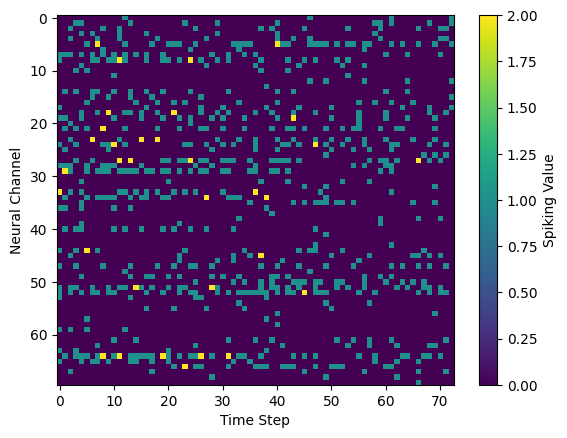

In [18]:
import numpy as np
import matplotlib.pyplot as plt


spiking_data = test_neural_data[0]
print("spiking_data:")
print(spiking_data)


# heatmap
plt.imshow(spiking_data.T, cmap='viridis', aspect='auto')
plt.colorbar(label='Spiking Value')  
plt.xlabel('Time Step')
plt.ylabel('Neural Channel')


plt.show()

# Phase1: Floating-point Training

## 1. Define hyperparameters

In [10]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

## 2. Define pathes for model log files and model checkpoints

In [11]:
logdir = os.path.join( spike_data_dir, 'lfads_log_fp')
modeldir = os.path.join( spike_data_dir, 'lfads_model_fp')

## 3. Get the model and dataset

In [12]:
T0 = datetime.now()

fp_model, x, y, validation_data, callbacks, adaptive_weights = Runtime.get_model(
    model_type=ModelType.LFADS,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5),
    model_settings=dict(
        factors=4,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed,
        quantized=False
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1000, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=2 # set to 2 to see the losses during training
)

INFO:tndm.utils.logging:Seed was set to 0


Seed was set to 0


## 4. Training and reload 

In [13]:
if retrain_fp_model:
    history = fp_model.fit(
        x=x,
        y=y,
        callbacks=callbacks,
        shuffle=True,
        epochs=1000,
        batch_size=16,
        validation_data=validation_data,
        verbose=2
    )

    fp_model.save(modeldir)

    print('Training took '+str(datetime.now()-T0))

In [14]:
print(modeldir)
fp_model = ModelLoader.load(modeldir, model_class=LFADS)

Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_fp


## 5. Check the performance

### a. Training data factors latent space

In [15]:
log_f, (g0, mean, logvar), z =  fp_model(neural_data.astype('float'), training=False)

Text(0.5, 1.0, 'Factors')

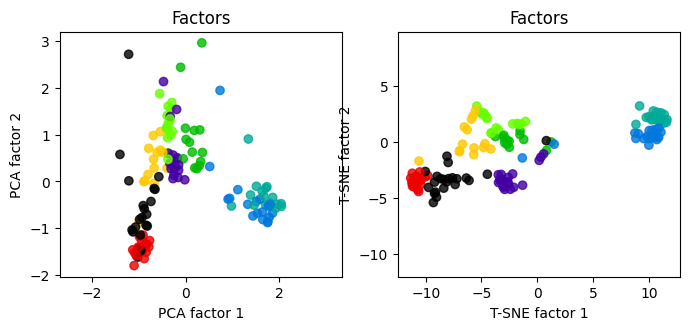

In [10]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


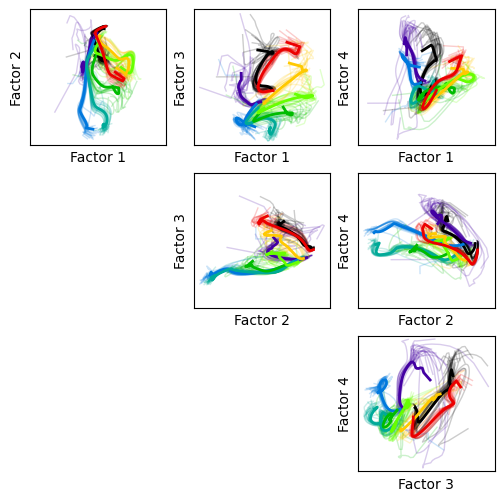

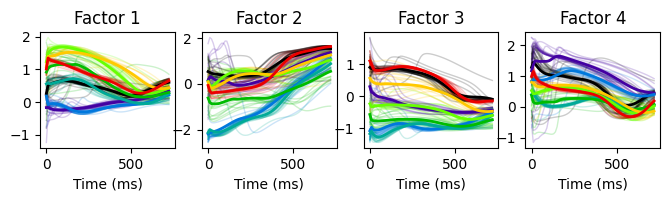

In [11]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


### b. Training data R2 Score

In [12]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

0.9180981710417347


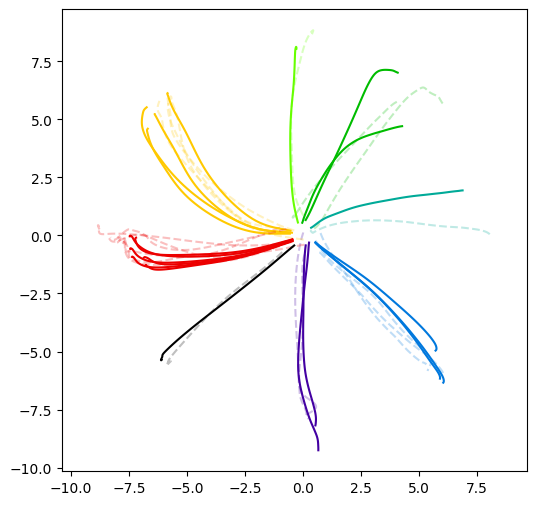

In [13]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [14]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 91.810%


### c. Testing data factors latent space

In [15]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    fp_model(test_neural_data.astype('float'), training=False)

Text(0.5, 1.0, 'Factors')

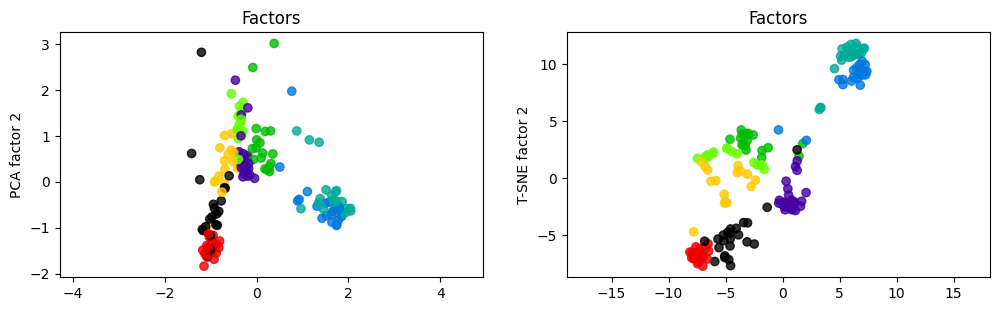

In [16]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


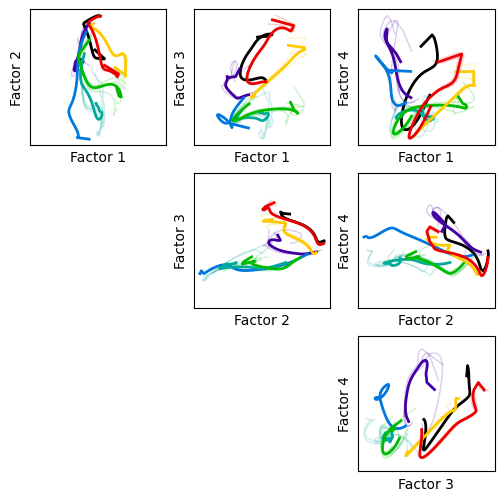

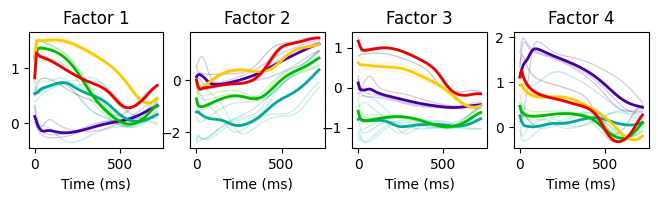

In [17]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


### d. Testing data R2 Score

In [18]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

0.9233394116196616


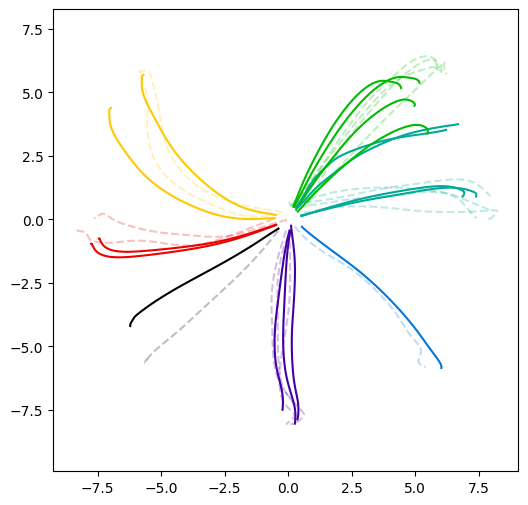

In [19]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [20]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 92.334%


### e. Trial-averaged firing rates and predictions
Computed from test+train data for better averages

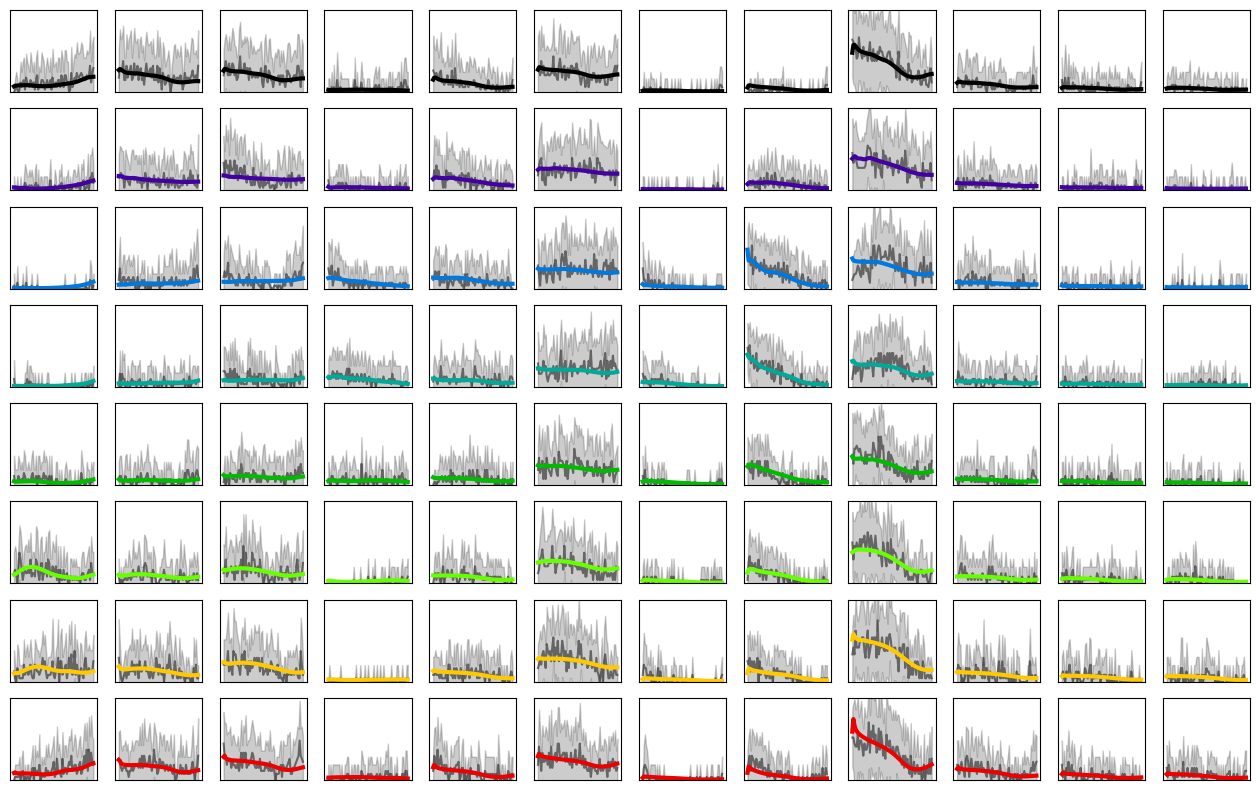

In [21]:
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]
    
    for i_n,n in enumerate(range(0,12)):
        ax = fig.add_subplot(8, 12, i*12+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
    

In [22]:
fp_model.summary()

Model: "lfads_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 EncoderRNN (Bidirectional)  multiple                  52224     
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 DenseMean (Dense)           multiple                  8256      
                                                                 
 DenseLogVar (Dense)         multiple                  8256      
                                                                 
 GaussianSampling (GaussianS  multiple                 0   

In [23]:
fp_model.quantized

False

# Phase2:　Quantization-aware Training
Transfer weight and finetune with quantization-aware training
Selection deleted


In [24]:
# qat model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [25]:
logdir = os.path.join( spike_data_dir, 'lfads_log_'+str(total_bit))
modeldir = os.path.join( spike_data_dir, 'lfads_model_'+str(total_bit))

In [26]:
T0 = datetime.now()

qat_model, x, y, validation_data, callbacks, adaptive_weights = Runtime.get_model(
    model_type=ModelType.LFADS,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-6),
    model_settings=dict(
        factors=4,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed,
        quantized=True,
        total_bit=total_bit
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1000, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=2 # set to 2 to see the losses during training
)

INFO:tndm.utils.logging:Seed was set to 0


Seed was set to 0


In [27]:
#load the floating-point model weight
qat_model.load_model_weight(fp_model)

In [28]:
'''
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss/reconstruction',
    min_delta=0,
    patience=10,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch = 200
)

model_checkopint_callback = tf.keras.callbacks.ModelCheckpoint(
    modeldir,
    monitor='val_loss/reconstruction',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
    initial_value_threshold=None,
)
'''

'\nearly_stop_callback = tf.keras.callbacks.EarlyStopping(\n    monitor=\'val_loss/reconstruction\',\n    min_delta=0,\n    patience=10,\n    verbose=1,\n    mode="min",\n    baseline=None,\n    restore_best_weights=True,\n    start_from_epoch = 200\n)\n\nmodel_checkopint_callback = tf.keras.callbacks.ModelCheckpoint(\n    modeldir,\n    monitor=\'val_loss/reconstruction\',\n    verbose=1,\n    save_best_only=True,\n    save_weights_only=False,\n    mode="min",\n    save_freq="epoch",\n    initial_value_threshold=None,\n)\n'

In [29]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, 
                 monitor='val_loss/reconstruction', 
                 min_delta=0, 
                 patience=10, 
                 verbose=1, 
                 mode='min', 
                 baseline=None, 
                 restore_best_weights=False, 
                 start_from_epoch=0):
        super(CustomEarlyStopping, self).__init__()

        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.mode = mode
        self.baseline = baseline
        self.restore_best_weights = restore_best_weights
        self.start_from_epoch = start_from_epoch
        self.wait = 0
        self.stopped_epoch = 0
        self.best_weights = None

        if mode == 'min':
            self.monitor_op = lambda current, best: current < best - min_delta
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = lambda current, best: current > best + min_delta
            self.best = float('-inf')
        else:
            raise ValueError(f"Unknown mode: {mode}. Choose 'min' or 'max'.")

    def on_train_begin(self, logs=None):
        if self.baseline is not None:
            self.best = self.baseline

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        if current is None:
            print(f"Early stopping requires {self.monitor} available!")
            return
        
        # If we are before the start_from_epoch, do nothing
        if epoch < self.start_from_epoch:
            return

        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights and self.best_weights is not None:
                    if self.verbose > 0:
                        print(f"Restoring model weights from the end of the best epoch: {self.best}")
                    self.model.set_weights(self.best_weights)
        
        if self.verbose > 0 and self.model.stop_training:
            print(f"Epoch {epoch + 1}: early stopping")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping triggered")


In [30]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, save_best_only=True, monitor='val_loss/reconstruction', mode='auto'):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.monitor = monitor
        self.best = None
        self.monitor_op = None

        if mode == 'min':
            self.monitor_op = tf.math.less
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = tf.math.greater
            self.best = float('-inf')
        else:
            if 'acc' in self.monitor or 'accuracy' in self.monitor:
                self.monitor_op = tf.math.greater
                self.best = float('-inf')
            else:
                self.monitor_op = tf.math.less
                self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        filepath = self.filepath
        current = logs.get(self.monitor)

        if current is None:
            return

        if self.save_best_only:
            if self.monitor_op(current, self.best):
                previous_best = self.best
                self.best = current
                self.model.save(filepath)
                print(f"Epoch {epoch + 1}: {self.monitor} improved from {previous_best:.5f} to {current:.5f}, saving model to {filepath}")
            else:
                print(f"Epoch {epoch + 1}: {self.monitor} did not improve from {self.best:.5f}")
        else:
            self.model.save(filepath)
            print(f"Epoch {epoch + 1}: {self.monitor} was {current:.5f}, saving model to {filepath}")

In [31]:
early_stop_callback = CustomEarlyStopping(
    monitor='val_loss/reconstruction', 
    patience=10, 
    start_from_epoch=200, 
    restore_best_weights=True
)


model_checkopint_callback = CustomModelCheckpoint(
    modeldir,
    save_best_only=True, 
    monitor='val_loss/reconstruction', 
    mode='min'
)

In [32]:
# add EarlyStopping and ModelCheckpoint
callbacks.extend([
    early_stop_callback,
    model_checkopint_callback
    ])

In [33]:
if all_quantized_retrain:
    history = qat_model.fit(
        x=x,
        y=y,
        callbacks=callbacks,
        shuffle=True,
        epochs=1000,
        batch_size=16,
        validation_data=validation_data,
        verbose=2
    )

    print('Training took '+str(datetime.now()-T0))

Epoch 1/1000


/home/pcslab/anaconda3/envs/lfads_hls4ml/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1: val_loss/reconstruction improved from inf to 2008.40991, saving model to Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_8
9/9 - 31s - loss: 2030.8782 - loss/loglike: 2029.3839 - loss/kldiv: 7.4631 - loss/reg: 115.7645 - loss/reconstruction: 2029.3839 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0020 - learning_rate: 0.0010 - val_loss: 2009.4492 - val_loss/loglike: 2008.4099 - val_loss/kldiv: 5.1955 - val_loss/reconstruction: 2008.4099 - lr: 0.0010 - 31s/epoch - 3s/step
Epoch 2/1000
Epoch 2: val_loss/reconstruction improved from 2008.40991 to 2000.40515, saving model to Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_8
9/9 - 31s - loss: 2023.3573 - loss/loglike: 2021.6558 - loss/kldiv: 8.4806 - loss/reg: 114.5330 - loss/reconstruction: 2021.6558 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0065 - learning_rate: 0.0010 - val_loss: 2001.5244 - val_loss/loglike: 2000.4052 - val_loss/kldiv: 5.5963 - val_loss/reconstruction: 2000.4052

KeyboardInterrupt: 

In [ ]:
print(modeldir)
qat_model = ModelLoader.load(modeldir, model_class=LFADS)

# Latent space

## Training data

In [ ]:
log_f, (g0, mean, logvar), z =  qat_model(neural_data.astype('float'), training=False)

In [ ]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


In [ ]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


In [ ]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

In [ ]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [ ]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

## Test data

In [ ]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    qat_model(test_neural_data.astype('float'), training=False)

In [ ]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


In [ ]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [ ]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

In [ ]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [ ]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

In [ ]:
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]
    
    for i_n,n in enumerate(range(0,12)):
        ax = fig.add_subplot(8, 12, i*12+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
    

In [ ]:
qat_model.summary()

# Turn customized model to h5 format

In [ ]:
decoder_dim = 64
def get_decoder_input(decoder_dim=64):
    inputs2decoder_train = tf.stack([tf.zeros_like(neural_data)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_val = tf.stack([tf.zeros_like(valid_neural_data)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_test = tf.stack([tf.zeros_like(test_neural_data)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_train = np.array(inputs2decoder_train)
    inputs2decoder_val = np.array(inputs2decoder_val)
    inputs2decoder_test = np.array(inputs2decoder_test)
    print("inputs2decoder_train shape: ", inputs2decoder_train.shape)
    print("inputs2decoder_val shape: ", inputs2decoder_val.shape)
    print("inputs2decoder_test shape: ", inputs2decoder_test.shape)
    return inputs2decoder_train, inputs2decoder_val, inputs2decoder_test
inputs2decoder_train, inputs2decoder_val, inputs2decoder_test = get_decoder_input(decoder_dim=decoder_dim)

In [ ]:
qat_model.summary()

In [ ]:
from tensorflow.keras import Model
import tensorflow.keras.layers as tfl
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

In [ ]:
import qkeras
from qkeras.utils import load_qmodel

In [ ]:
input_shape = (73,70)
inputs = tfl.Input(shape=input_shape, name = 'encoder_input')
decode_input_shape = (73,decoder_dim)
decode_inputs = tfl.Input(shape=decode_input_shape, name = 'decoder_input')

In [ ]:
encoder_GRU = qat_model.get_layer("EncoderRNN")
dense_mean = qat_model.get_layer("DenseMean")
dense_logvar = qat_model.get_layer("DenseLogVar")
decoder_GRU = qat_model.get_layer("DecoderGRU")
dense = qat_model.get_layer("Dense")
neural_dense = qat_model.get_layer("NeuralDense")
# Activation
q_act_dense_mean = qat_model.get_layer("q_act_dense_mean")
q_act_dense_logvar = qat_model.get_layer("q_act_dense_logvar")
q_act_postencoder = qat_model.get_layer("q_act_postencoder")
q_act_postsampling = qat_model.get_layer("q_act_postsampling")
q_act_predecoder = qat_model.get_layer("q_act_predecoder")
q_act_postdecoder = qat_model.get_layer("q_act_postdecoder")
q_act_postdense = qat_model.get_layer("q_act_postdense")

In [ ]:
# encode
encoder_GRU_out = encoder_GRU(inputs)
q_act_postencoder_out = q_act_postencoder(encoder_GRU_out)
dense_mean_out = dense_mean(q_act_postencoder_out)
q_act_dense_mean_out = q_act_dense_mean(dense_mean_out)
#dense_logvar_out = dense_logvar(q_act_postencoder_out)
#q_act_dense_logvar_out = q_act_dense_logvar(dense_logvar_out)
#dense_logvar_out = tf.math.log(tf.exp(dense_logvar_out + 0.0001))

#epsilon = StandardRandomNormal()(q_act_dense_mean_out)

#z_var = ExponentLogvar()(q_act_dense_logvar_out)

#z_var = tfl.Multiply()([z_var, epsilon])

#z_out = tfl.Add()([q_act_dense_mean_out, z_var])

#q_act_postsampling_out = q_act_postsampling(z_out)
#q_act_postsampling_out = q_act_postsampling(q_act_dense_mean_out)

# decode
#q_act_predecoder_out = q_act_predecoder(q_act_dense_mean_out)
#decoder_GRU_out = decoder_GRU(decode_inputs, initial_state = q_act_predecoder_out)
decoder_GRU_out = decoder_GRU(decode_inputs, initial_state = q_act_dense_mean_out)
q_act_postdecoder_out = q_act_postdecoder(decoder_GRU_out)
dense_out = dense(q_act_postdecoder_out)
q_act_postdense_out = q_act_postdense(dense_out)
neural_dense_out = neural_dense(q_act_postdense_out)

In [ ]:
lfad_full = Model(inputs = [inputs, decode_inputs], outputs = [q_act_postdense_out, neural_dense_out], name="lfad_full")
lfad_for_hls4ml = Model(inputs = [inputs, decode_inputs], outputs = neural_dense_out, name="lfad_for_hls4ml")


In [ ]:
plot_model(lfad_full)

In [ ]:
z, _ =  lfad_full.predict([neural_data.astype('float'), inputs2decoder_train])
X = np.transpose(z[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]
b_reshape = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
behavioural_data_reshape  = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
r2 = r2_score(behavioural_data_reshape , b_reshape)
print('h5 qmodel train behaviour R2 score : {:.3%}'.format(r2))

In [ ]:
pred_z_test, _ =  lfad_full.predict([test_neural_data.astype('float'), inputs2decoder_val])
Xt = np.transpose(pred_z_test[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_test.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('h5 qmodel test behaviour R2 score : {:.3%}'.format(reg.score(Xt, yt)))

In [ ]:
print("model save in: "+modeldir+'.h5')
lfad_full.save(modeldir+'.h5')

print("qmodel for hls4ml save in: "+ qmodels_for_hls4ml_dir)
lfad_for_hls4ml.save(qmodels_for_hls4ml_dir)

In [ ]:
lfad_full = load_qmodel(
    modeldir+'.h5',
     compile = False
)

In [ ]:
z, _ =  lfad_full.predict([neural_data.astype('float'), inputs2decoder_train])
X = np.transpose(z[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]
b_reshape = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
behavioural_data_reshape  = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
r2 = r2_score(behavioural_data_reshape , b_reshape)
print('h5 qmodel train behaviour R2 score : {:.3%}'.format(r2))

In [ ]:
pred_z_test, _ =  lfad_full.predict([test_neural_data.astype('float'), inputs2decoder_val])
Xt = np.transpose(pred_z_test[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_test.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('h5 qmodel test behaviour R2 score : {:.3%}'.format(reg.score(Xt, yt)))

In [ ]:
lfad_full.summary()

In [ ]:
plot_model(lfad_full)